# Setup

In [ ]:
# installation of required libraries
!pip install biopandas ifeatureomegacli rdkit biopython

In [ ]:
!rm -rf /content/*

# Data exploration

# Load the protein data

In [ ]:
from biopandas.pdb import PandasPdb
import pandas as pd

Note: Why is `biopandas` useful for protein analysis?

If you work with PDB files and want to analyze protein structures efficiently in Python, biopandas makes it easier by converting structural data into Pandas DataFrames.
Key Benefits for a Computational Protein Workshop

- **Easy Data Handling**: Instead of looping through PDB files manually, you can use biopandas to extract atomic coordinates, residue information, and chain details into a structured DataFrame.
- **Fast Filtering**: Need only backbone atoms, a specific chain, or only hydrophobic residues? Use simple pandas filtering instead of complex parsing.
- **Compatible with ML & Visualization**: Since biopandas works with DataFrames, it’s easier to integrate protein structural data into machine learning pipelines or use matplotlib for visualization.
- **No Complex Parsing**: Unlike `Bio.PDB` (which requires object-oriented access), biopandas lets you query PDB data like a spreadsheet, making it more beginner-friendly.


In [ ]:
PDB_FILE_LOCATION = 'https://github.com/enveda/modbioterp-enveda/raw/refs/heads/main/workshop_data/cotb2_pp_mg.pdb'
!wget $PDB_FILE_LOCATION -O /content/cotb2_pp_mg.pdb

In [ ]:
!ls /content

In [ ]:
pdb_file = PandasPdb().read_pdb('/content/cotb2_pp_mg.pdb')

In [ ]:
display(
    pdb_file.df["ATOM"].head(3),
    pdb_file.df["HETATM"].head(3)
)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

pdb_file.df["ATOM"].groupby("residue_name").size().plot(kind="bar", figsize=(10, 5), color='green')
_ = plt.xticks(rotation=90)

# Extract the sequence from the protein file and write it into a fasta file

In [ ]:
# the mapping of 3 letter AA to 1 letter
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'HSE': 'H', 'HSP': 'H', 'HSD': 'H', 'HIE': 'H', 'HID': 'H',
}

In [ ]:
grouped_amino_acids = pdb_file.df["ATOM"].groupby(["residue_number"]).first()
grouped_amino_acids.head()

In [ ]:
sequence = "".join(grouped_amino_acids['residue_name'].map(aa_dict))
display(sequence)

### Answer 🏗

there are Mg and Pop (lipids) in the pandas dataframe. If you do

```python
set(aa_dict.keys()) - set(grouped_amino_acids["residue_name"])
```
you should see
```python
['MG', 'POP']
```

indicating that you must get rid of these somehow. One easy way is to simply do
```python
sequence = "".join(grouped_amino_acids['residue_name'].map(aa_dict).dropna())
```

In [ ]:
sequence = "".join(grouped_amino_acids['residue_name'].map(aa_dict).dropna())
display(sequence)

---

In [ ]:
# how to write a fasta file

fasta_location = "cotb2_mg.fasta"
with open(fasta_location, "w") as f:
    f.write(f">cotb2_mg\n{sequence}")

# Find the amino acid composition (AAC)

,aa,frequency
0,ASP,0.0865
1,VAL,0.0801
2,ALA,0.0769
3,THR,0.0769
4,ARG,0.0705


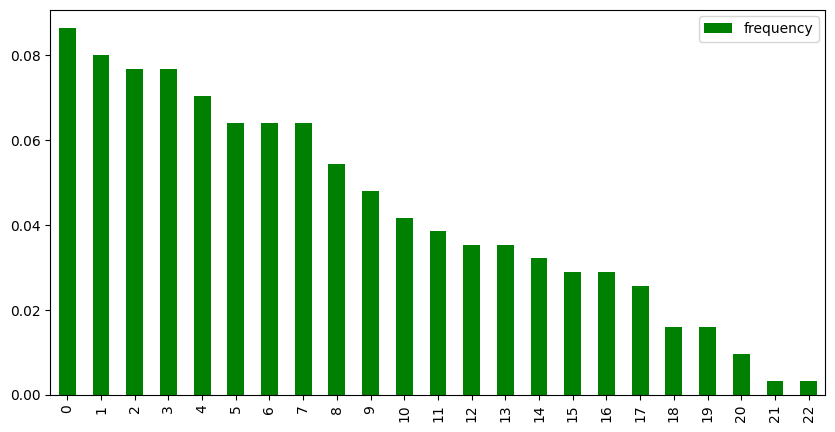

In [ ]:
# get raw counts
aac = pdb_file.df["ATOM"].groupby(["residue_number"]).first().residue_name.value_counts().to_dict()

# normalize to length of sequence
aac = {k:round(v/sum(aac.values()),4) for k,v in aac.items()}

counts = pd.DataFrame(aac.items(), columns = ["aa", "frequency"]).sort_values(by = "frequency", ascending = False)
display(counts.head())

# plot it
counts.plot(kind = "bar", figsize = (10,5), color = "green")
_ = plt.xticks(rotation = 90)

# Find Dipeptide composition (DC)

In [ ]:
unique_sequence_list = list(set(aa_dict.values()))
dipeptides = []
for first_aa in unique_sequence_list:
  for second_aa in unique_sequence_list:
    dipeptides.append(first_aa + second_aa)

In [ ]:
from collections import Counter

# Generate dipeptides (two consecutive amino acids)
dipeptides_in_protein = [sequence[i:i+2] for i in range(len(sequence)-1)]

# Count dipeptide occurrences
dipeptide_counts = Counter(dipeptides_in_protein)

In [ ]:
dipeptides_dictionary = {}
for current_peptide in dipeptides:
  dipeptides_dictionary[current_peptide] = 0
  if current_peptide in dipeptide_counts:
    dipeptides_dictionary[current_peptide] = dipeptide_counts[current_peptide]
    
# Normalize to get relative frequencies
total_dipeptides = sum(dipeptides_dictionary.values())
dipeptide_freq = {dp: count / total_dipeptides for dp, count in dipeptide_counts.items()}

pd.DataFrame(dipeptide_freq.items(), columns = ["dipeptide", "frequency"]).sort_values(by = "frequency", ascending = False)

# Protein Feature extraction

**Other packages you could use to featurize proteins:**

1. [propy](https://github.com/MartinThoma/propy3):

- Computes AAC, DC, Pseudo-AAC
- good for classical ML features

2. [biovec](https://github.com/kyu999/biovec)
-	Converts protein sequences into word embeddings (like Word2Vec).
-	Trains on k-mers from protein sequences.
-	Useful for deep learning models

3. [fair-esm](https://github.com/facebookresearch/esm)

- evolutionary scale modeling
- Extracts deep learning embeddings for proteins.
- Uses pre-trained transformers
- Great for deep learning tasks

In [ ]:
unique_sequence_list = list(set(aa_dict.values()))
dipeptides = []
for first_aa in unique_sequence_list:
  for second_aa in unique_sequence_list:
    dipeptides.append(first_aa + second_aa)

In [ ]:
from collections import Counter

# Generate dipeptides (two consecutive amino acids)
dipeptides_in_protein = [sequence[i:i+2] for i in range(len(sequence)-1)]

# Count dipeptide occurrences
dipeptide_counts = Counter(dipeptides_in_protein)

In [ ]:
dipeptides_dictionary = {}
for current_peptide in dipeptides:
  dipeptides_dictionary[current_peptide] = 0
  if current_peptide in dipeptide_counts:
    dipeptides_dictionary[current_peptide] = dipeptide_counts[current_peptide]
    
# Normalize to get relative frequencies
total_dipeptides = sum(dipeptides_dictionary.values())
dipeptide_freq = {dp: count / total_dipeptides for dp, count in dipeptide_counts.items()}

pd.DataFrame(dipeptide_freq.items(), columns = ["dipeptide", "frequency"]).sort_values(by = "frequency", ascending = False)

In [ ]:
import iFeatureOmegaCLI

protein_features = iFeatureOmegaCLI.iProtein(fasta_location)

In [ ]:
help(protein_features)

Help on iProtein in module iFeatureOmegaCLI.iFeatureOmegaCLI object:

class iProtein(Sequence)
 |  iProtein(file)
 |  
 |  # Running examples:
 |  # import iFeatureOmegaCLI
 |  >>> import iFeatureOmegaCLI
 |  
 |  # create a instance
 |  >>> protein = iFeatureOmegaCLI.iProtein("./data_examples/peptide_sequences.txt")
 |  
 |  # display available feature descriptor methods
 |  >>> protein.display_feature_types()
 |  
 |  # import parameters for feature descriptors (optimal)
 |  >>> protein.import_parameters('parameters/Protein_parameters_setting.json')
 |  
 |  # calculate feature descriptors. Take "AAC" as an example.
 |  >>> protein.get_descriptor("AAC")
 |  
 |  # display the feature descriptors
 |  >>> print(protein.encodings)
 |  
 |  # save feature descriptors
 |  >>> protein.to_csv("AAC.csv", "index=False", header=False)
 |  
 |  Method resolution order:
 |      iProtein
 |      Sequence
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  CalculateContent(self, myDist

In [ ]:
protein_features.display_feature_types()


        ----- Available feature types ------        
        
        AAC                                                Amino acid composition
        EAAC                                               Enhanced amino acid composition
        CKSAAP type 1                                      Composition of k-spaced amino acid pairs type 1 - normalized
        CKSAAP type 2                                      Composition of k-spaced amino acid pairs type 2 - raw count
        DPC type 1                                         Dipeptide composition type 1 - normalized
        DPC type 2                                         Dipeptide composition type 2 - raw count
        TPC type 1                                         Tripeptide composition type 1 - normalized
        TPC type 2                                         Tripeptide composition type 1 - raw count
        CTDC                                               Composition
        CTDT                                      

# Now generate Features using the help docs

In [ ]:
descriptor_blocks = ["AAC", "DistancePair", "BLOSUM62"]
protein_features = []
protein_features_names = []

PF = iFeatureOmegaCLI.iProtein(fasta_location)

for current_descriptor_block in descriptor_blocks:
    PF.get_descriptor(current_descriptor_block)
    current_features_table = PF.encodings.reset_index(drop=True)
    protein_features += current_features_table.values[0].tolist()
    protein_features_names += current_features_table.columns.tolist()

# Plot energies of the Small molecules

,ligand,energy
0,lig_1_cotb2_100_100.pdb,-21.457340
1,lig_1_cotb2_100_10.pdb,-44.423028
2,lig_1_cotb2_100_11.pdb,-29.692781
3,lig_1_cotb2_100_12.pdb,-0.501767
4,lig_1_cotb2_100_13.pdb,-28.634483


(10000, 2)

<AxesSubplot:>

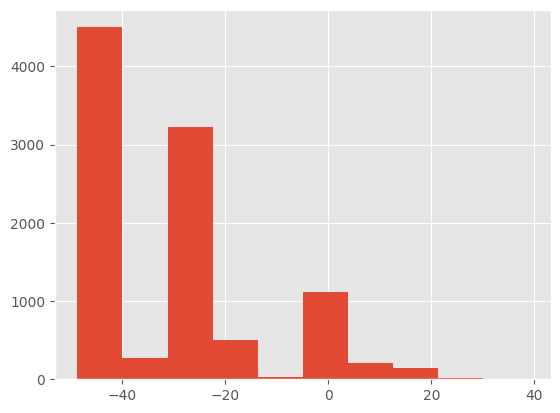

In [ ]:
%matplotlib inline

energies = 'https://github.com/enveda/enzyme-ml/raw/refs/heads/main/workshop_data/cotb2_ml_data/lig_1_energy.txt'
loaded_ligands = pd.read_csv(energies, header = None, sep=" ")
loaded_ligands.columns = ["ligand", "energy"]
display(loaded_ligands.head(5), loaded_ligands.shape)
loaded_ligands.energy.hist()

In [ ]:
import os

# get ligands
!wget "https://github.com/enveda/enzyme-ml/raw/refs/heads/main/workshop_data/cotb2_ml_data/lig_1_pdbs.tar" -O /content/lig_1_pdbs.tar
!mkdir -p ligands
!tar -xf /content/lig_1_pdbs.tar -C ligands

files = os.listdir("/content/ligands")
print(f"Number of files: {len(files)}")

--2025-03-11 16:19:26--  https://github.com/enveda/enzyme-ml/raw/refs/heads/main/workshop_data/cotb2_ml_data/lig_1_pdbs.tar
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/enveda/enzyme-ml/refs/heads/main/workshop_data/cotb2_ml_data/lig_1_pdbs.tar [following]
--2025-03-11 16:19:27--  https://raw.githubusercontent.com/enveda/enzyme-ml/refs/heads/main/workshop_data/cotb2_ml_data/lig_1_pdbs.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51210240 (49M) [application/octet-stream]
Saving to: ‘/content/lig_1_pdbs.tar’

/content/lig_1_pdbs 100%[===================>]  48.84M   173MB/s    in 0.3s    

# Generate 3d descriptors using rdkit for all 10000 molecules

In [ ]:
from rdkit import Chem
from tqdm import tqdm

for idx, row in tqdm(loaded_ligands.iterrows()):
  file_name = row["ligand"]
  file_path = "/content/ligands/" + file_name

  try:
    mol = Chem.MolFromPDBFile(file_path, removeHs=True)
    loaded_ligands.loc[idx, "mol"] = mol

    descriptors = Chem.Descriptors3D.CalcMolDescriptors3D(mol)
    for k,v in descriptors.items():
      loaded_ligands.loc[idx, k] = v
  except Exception as e:
    loaded_ligands.loc[idx, "mol"] = None
    continue

10000it [00:45, 220.91it/s]


In [ ]:
loaded_ligands = loaded_ligands.dropna(subset = ["mol"])
loaded_ligands["smiles"] = loaded_ligands["mol"].apply(lambda x: Chem.MolToSmiles(x))
loaded_ligands.head(5)

,ligand,energy,mol,PMI1,PMI2,PMI3,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,Eccentricity,Asphericity,SpherocityIndex,PBF,smiles
0,lig_1_cotb2_100_100.pdb,-21.457340,<rdkit.Chem.rdchem.Mol object at 0x7f43275a97e0>,858.038436,1583.425000,2184.329171,0.392816,0.724902,3.102941,0.000845,0.919617,0.247343,0.166761,0.576983,CC1CCCC(C)CCC2(C)CCC(C(C)C)C2CC1
1,lig_1_cotb2_100_10.pdb,-44.423028,<rdkit.Chem.rdchem.Mol object at 0x7f43275a98c0>,849.158235,1572.291482,2074.488795,0.409334,0.757918,3.059078,0.000893,0.912385,0.225252,0.231516,0.650322,CC1CCCC(C)CCC2(C)CCC(C(C)C)C2CC1
2,lig_1_cotb2_100_11.pdb,-29.692781,<rdkit.Chem.rdchem.Mol object at 0x7f43275a9930>,790.542596,1615.008980,2102.130286,0.376067,0.768273,3.063071,0.000972,0.926592,0.259586,0.201936,0.651273,CC1CCCC(C)CCC2(C)CCC(C(C)C)C2CC1
3,lig_1_cotb2_100_12.pdb,-0.501767,<rdkit.Chem.rdchem.Mol object at 0x7f43275a99a0>,882.532834,1438.458730,2037.900117,0.433060,0.705853,3.012094,0.000800,0.901365,0.210870,0.194837,0.590767,CC1CCCC(C)CCC2(C)CCC(C(C)C)C2CC1
4,lig_1_cotb2_100_13.pdb,-28.634483,<rdkit.Chem.rdchem.Mol object at 0x7f43275a9a10>,776.232018,1621.679340,2083.545226,0.372553,0.778327,3.054148,0.001003,0.928011,0.262621,0.210445,0.667377,CC1CCCC(C)CCC2(C)CCC(C(C)C)C2CC1


In [ ]:
loaded_ligands.smiles.value_counts()

,count
smiles,
CC1CCCC(C)CCC2(C)CCC(C(C)C)C2CC1,10000


# Plot the distribution of the descriptors

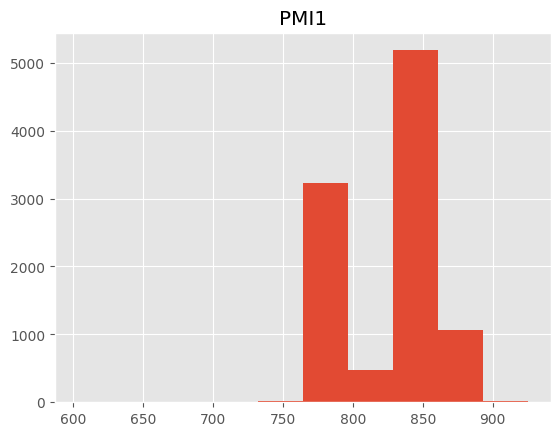

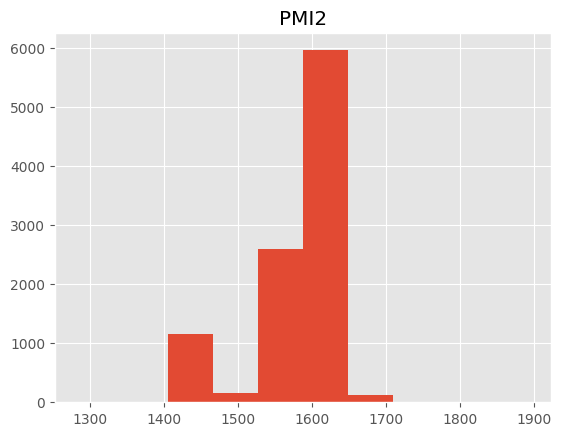

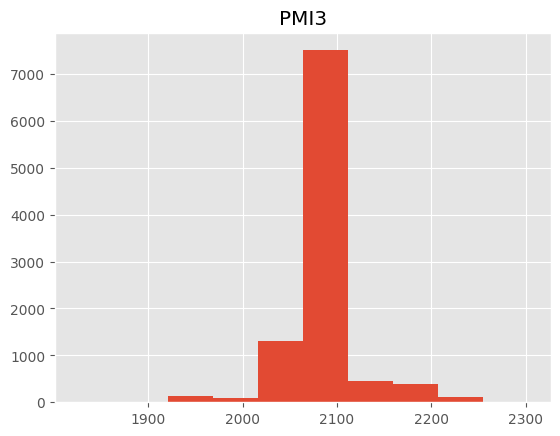

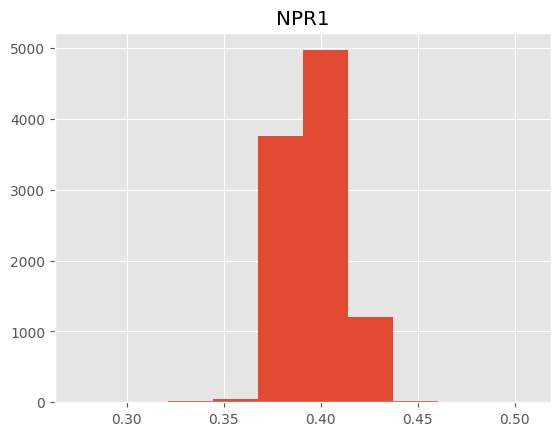

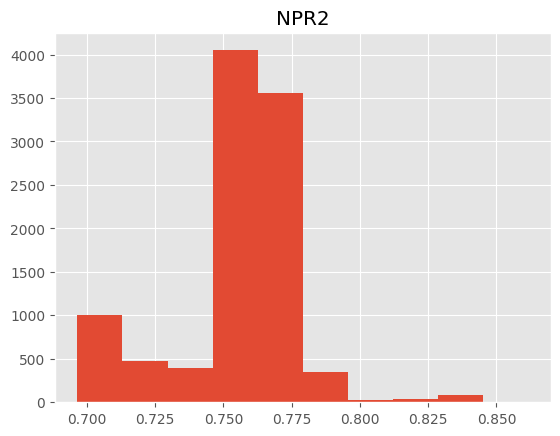

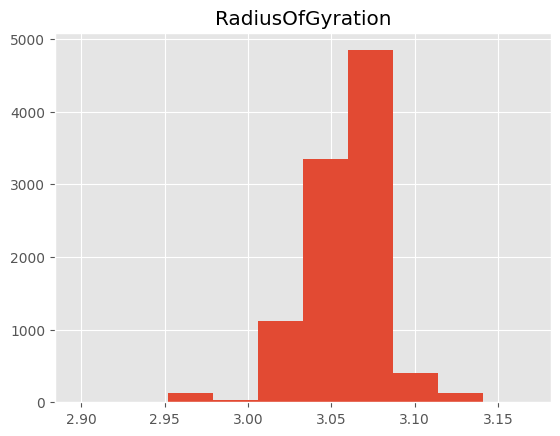

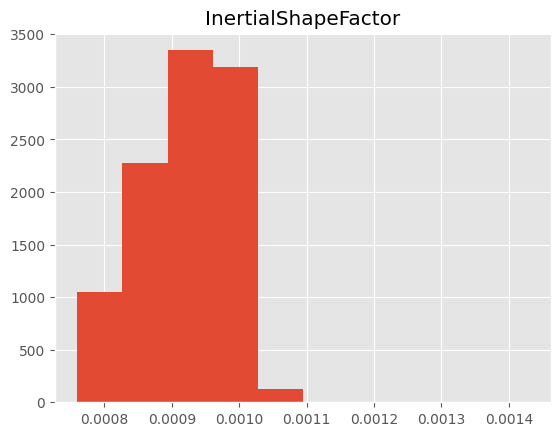

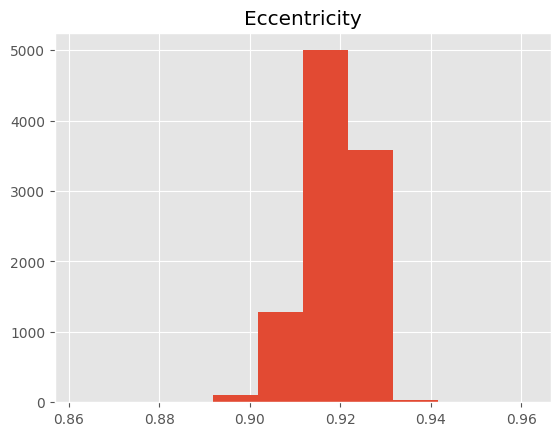

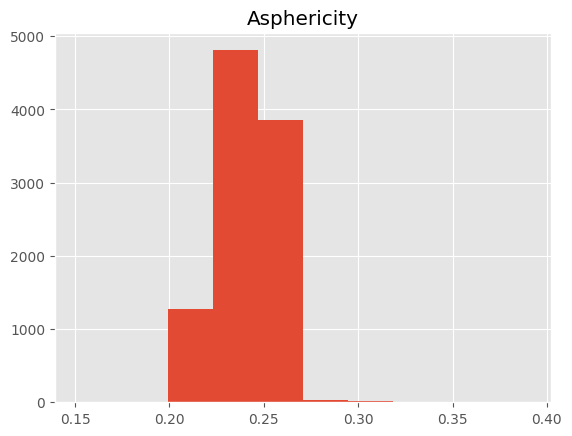

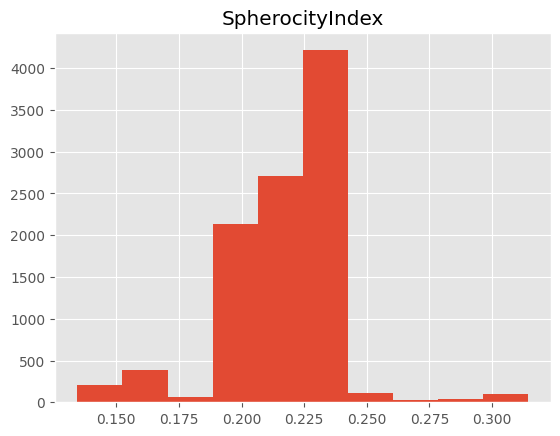

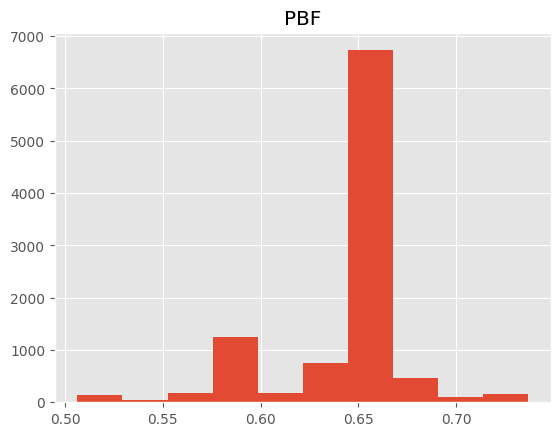

In [ ]:
%matplotlib inline

for col in descriptors.keys():
  loaded_ligands[col].hist()
  plt.title(col)
  plt.show()